In [1]:
import rosbag, rospy
from sensor_msgs.msg import Image, CameraInfo
from image_geometry import PinholeCameraModel
import tf

import cv2
from cv_bridge import CvBridge, CvBridgeError

import json, yaml
import glob, random, math
from scipy.optimize import minimize

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# BGR to RGB conversion for opencv to matplotlib format
def BGR2RGB(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Explore rosbag 
In the first terminal, run :

```
rosbag play -l -r 5 2017-04-19-15-38-28.bag
```
`-l` option plays the bag in loop,   
`-r 5` option speeds up the video 5 times.

In the second terminal, type 
```
rostopic list
```

Here is the way to get same info in python. Following is the list of topics in the calibration rosbag :

In [3]:
filename = '2017-04-19-15-38-28.bag'
bag = rosbag.Bag(filename)
info = bag.get_type_and_topic_info()
info.topics.keys()

IOError: [Errno 2] No such file or directory: '2017-04-19-15-38-28.bag'

### Load camera intrinsic calibration data

Almost all ROS packages for projection transformations require 'CameraInfo' topic. Unfortunately, this topic is missing in the rosbag, instead we are provided with yaml file. We will use this yaml file to load the calibration data into 'CameraInfo' :

In [4]:
def load_cam_info():
    with open('ost.yaml','r') as cam_calib_file :
        cam_calib = yaml.load(cam_calib_file)
        cam_info = CameraInfo()
        cam_info.height = cam_calib['image_height']
        cam_info.width = cam_calib['image_width']
        cam_info.K = cam_calib['camera_matrix']['data']
        cam_info.D = cam_calib['distortion_coefficients']['data']
        cam_info.R = cam_calib['rectification_matrix']['data']
        cam_info.P = cam_calib['projection_matrix']['data']
        cam_info.distortion_model = cam_calib['distortion_model']
        return cam_info
    
cameraModel = PinholeCameraModel()
cam_info = load_cam_info()
cameraModel.fromCameraInfo(cam_info)

### Extract frames from rosbag

I have selected 3 frames for calibration. 
Assuming rosbag is playing, run rviz in another terminal:
```
rosrun rviz rviz
```
After changing the system frame to velodyne, point cloud should be visible. By pausing rosbag as required (make sure to note the time), individual frames can be analyzed. Using selection tool, individual points of interest can be selected. The coordinates of the points are noted in `calib.json`. Below I have extracted images for the corresponding frames. The camera pixels for the points of interest are also recorded in `calib.json`. 

In [5]:
with open('calib.json', 'r') as calib_file :
    poi = json.load(calib_file)
n_frames = len(poi)

# # time frames to use for calibration
# frames = [poi[i]['timestamp'] for i in range(n_frames)]
# save_dir = 'images/'

# # save calibration images
# bridge = CvBridge()
# img_index = 0
# for t in frames :
#     with rosbag.Bag(filename, 'r') as bag:
#         start_time = rospy.Time.from_sec(t)
#         for topic, msg, t in bag.read_messages(start_time=start_time, topics='/image_raw'):
#             if topic == "/image_raw" :
#                 try :
#                     cv_image = bridge.imgmsg_to_cv2(msg, "bgr8")
#                 except CvBridgeError, e:
#                     print e
#                 img_index += 1
#                 image_name = save_dir+str(img_index).zfill(2)+".jpg"
#                 cv2.imwrite(image_name, cv_image)    
#                 break

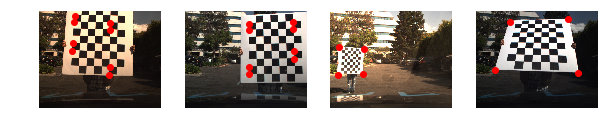

In [6]:
images = sorted(glob.glob('images/*'))
fig, axes = plt.subplots(1, 4, figsize=(10,8))

for frame, img_file, ax in zip(poi, images, axes) :
    img = cv2.imread(img_file)
    img = BGR2RGB(img)
    ax.imshow(img)
    pts = np.array(frame['camera'])
    ax.scatter(pts.T[0], pts.T[1], c='red')
    ax.axis('off')

## Lidar-camera calibration 

There are 6 parameters for lidar-camera calibration :
* 3 translation parameters : tx, ty, tz
* 3 rotation angles (Euler angles) : yaw, pitch, roll

Out goal is to find these parameters using calibration data. The 6 parameters are initialized to random numbers in a reasonable range and the camera pixels are predicted using lidar points and applying translation and rotation matrix constructed using these 6 parameters. The goal is to minimize the error (cost function) between actual camera pixel coordinates and the predicted corrdinates.   

In [7]:
def costFunc(x) :
    tx, ty, tz, yaw, pitch, roll = x
    translation = [tx, ty, tz, 1]
    rotationMatrix = tf.transformations.euler_matrix(roll, pitch, yaw)
    rotationMatrix[:, 3] = translation

    error = 0
    for frame in poi[:-1] :
        for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
            rotated_pt = rotationMatrix.dot(pt_cloud+[1])
            pt_cam_pred = cameraModel.project3dToPixel(rotated_pt)
            diff = np.array(pt_cam_pred) - np.array(pt_cam)
            error += math.sqrt(np.sum(diff**2))
    return error

In [15]:
def costFunc_cv2(x) :
    tx, ty, tz, rx, ry, rz = x
    translation = [tx, ty, tz, 1]
    rotationMatrix = tf.transformations.euler_matrix(roll, pitch, yaw)
    rotationMatrix[:, 3] = translation
    
    rotVect=np.array([rx, ry, rz])
    transVect=np.array([tx, ty, tz])
    intrinsicMatrix=np.array(cameraModel.intrinsicMatrix())
    distCoeffs=np.array(cameraModel.distortionCoeffs()).reshape((1,5))

    error = 0
    for frame in poi[:-1] :
        for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
            points = np.array([pt_cloud])
            pt_cam_pred, jacobia=cv2.projectPoints(points,rotVect,transVect,intrinsicMatrix,distCoeffs)
            diff = pt_cam_pred.reshape((2,)) - np.array(pt_cam)
            error += math.sqrt(np.sum(diff**2))
    return error

In [9]:
np.array(frame['camera'][0]).shape

(2,)

occasionally, the optimization procedure gets stuck in the wrong minima. So, I run this step a few times each with different random initializations to find the best solution. 

In [16]:
n_iter = 50
two_pi = 2*math.pi
bounds = [[-5,5]]*3 + [[-two_pi, two_pi]]*3

final_result = None
for i in range(n_iter):
    x = [random.uniform(bound[0],bound[1]) for bound in bounds]
    result = minimize(costFunc_cv2, x, bounds = bounds, method = 'SLSQP', options = { 'disp': True, 'maxiter': 1000 })
    if not final_result :
        final_result = result
    else :
        if result.fun < final_result.fun : final_result=result

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1671177.1172
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 394.53679483
            Iterations: 38
            Function evaluations: 323
            Gradient evaluations: 37
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 8169531.73622
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5265.36416787
            Iterations: 56
            Function evaluations: 465
            Gradient evaluations: 56
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 394.536794447
            Iterations: 38
            Function evaluations: 343
     

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5265.36416798
            Iterations: 136
            Function evaluations: 1127
            Gradient evaluations: 136
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 394.536794977
            Iterations: 57
            Function evaluations: 495
            Gradient evaluations: 57
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5265.36416788
            Iterations: 92
            Function evaluations: 759
            Gradient evaluations: 92
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5265.3641679
            Iterations: 107
            Function evaluations: 896
            Gradient evaluations: 107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5265.36416786
            Iterations: 45
            Function evaluations: 38

In [17]:
final_result

     fun: 394.5367944390391
     jac: array([-0.36818314,  0.02687073,  0.11251068,  0.63840103, -0.34854889,
        0.25406647])
 message: 'Optimization terminated successfully.'
    nfev: 440
     nit: 51
    njev: 51
  status: 0
 success: True
       x: array([ -1.50231172e-03,  -4.00842946e-01,  -5.30289086e-01,
        -2.41054475e+00,   2.41781181e+00,  -2.46716659e+00])

**Results** : 

Calibration parameters : 

* tx    =  0.0075
* ty    = -0.4046
* tz    = -0.5137
* yaw   = -1.6678
* pitch = -1.5988
* roll  = -3.0542

**Checks :**
Note the last image is a test image, it wasn't used for calibration.

(-476.71885871654547, -173.89729213552232)
(-426.06822443309022, -168.95346685049077)
(-101.61868702715574, -127.81218470922045)
(-59.882110992496202, -115.39491390518471)
(-326.62236608490434, 221.14370888653005)
(-283.44620248332569, 225.31865973939287)
(110.44533478780789, 224.46437093065464)
(142.36027385332022, 224.07584288882671)
(-337.11728050159439, 140.0853099664146)
(-294.95981143208263, 140.85776855961112)
(111.80443866979766, 171.43724182605146)
(142.637427556451, 170.46377362388753)
(-293.6428029576046, 531.14382936827724)
(-255.85663789970246, 523.23564238129563)
(-10.238022523419273, 513.7473480957857)
(19.979750800692479, 513.4175082189447)
(-520.3860708373993, -1037.7451597234376)
(-87.380337617844432, -869.17103411335881)
(-475.10907960267969, -590.30758129365847)
(-100.40488252030524, -499.64329395317606)
(-516.27632116702682, -266.11802456737007)
(186.26604371692105, -150.87865010713216)
(-412.39329972754109, 395.97696315082089)
(153.09806953530136, 467.295609079093

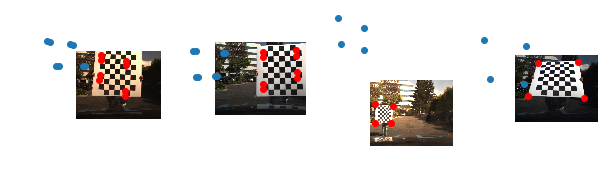

In [18]:
x = final_result.x
tx, ty, tz, yaw, pitch, roll = x
translation = [tx, ty, tz, 1]
rotationMatrix = tf.transformations.euler_matrix(roll, pitch, yaw)
rotationMatrix[:, 3] = translation

fig, axes = plt.subplots(1, 4, figsize=(10,8))

for frame, img_file, ax in zip(poi, images, axes) :
    img = cv2.imread(img_file)
    img = BGR2RGB(img)
    ax.imshow(img)
    pts = np.array(frame['camera'])
    ax.scatter(pts.T[0], pts.T[1], c='red')
    ax.axis('off')
    pts_pred = []
    for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
        rotated_pt = rotationMatrix.dot(pt_cloud+[1])
        pts_pred.append(cameraModel.project3dToPixel(rotated_pt))
        print(cameraModel.project3dToPixel(rotated_pt))
    pts_pred = np.array(pts_pred)
    ax.scatter(pts_pred.T[0], pts_pred.T[1])

# use cv2

('intrinsicMatrix=', array([[  1.38462156e+03,   0.00000000e+00,   6.25888005e+02],
       [  0.00000000e+00,   1.39365227e+03,   5.59626310e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]))
('distCoeffs=', array([[-0.152089,  0.270168,  0.003143, -0.00564 ,  0.      ]]))
('rotVect=', array([-2.41054475,  2.41781181, -2.46716659]))
('transVect=', array([-0.00150231, -0.40084295, -0.53028909]))
[[[ 397.42658334   71.5696881 ]]]
[[[ 397.07594909  115.03297916]]]
[[[ 373.61922217  402.57467398]]]
[[[ 374.61152059  442.39472851]]]
[[[ 804.15125002  152.35578125]]]
[[[ 805.50415304  188.70531125]]]
[[[ 792.67861002  657.46721476]]]
[[[ 791.30526912  704.25005108]]]
[[[ 709.97733372  154.11399341]]]
[[[ 711.04976325  197.46935454]]]
[[[ 717.10554006  659.58666634]]]
[[[ 711.81481121  701.57613312]]]
[[[ 1214.99926039   132.57382545]]]
[[[ 1211.49389054   182.3414146 ]]]
[[[ 1235.14013547   480.79843538]]]
[[[ 1240.47888089   524.57031222]]]
[[[ 105.69649875  433.34134094

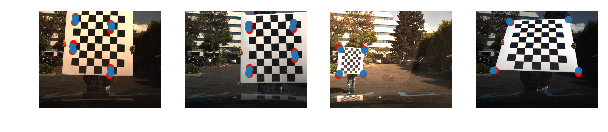

In [19]:
x = final_result.x
tx, ty, tz, rx, ry, rz = x

rotVect=np.array([rx, ry, rz])
transVect=np.array([tx, ty, tz])
intrinsicMatrix=np.array(cameraModel.intrinsicMatrix())
distCoeffs=np.array(cameraModel.distortionCoeffs()).reshape((1,5))
print('intrinsicMatrix=',intrinsicMatrix)
print('distCoeffs=',distCoeffs)
print('rotVect=',rotVect)
print('transVect=',transVect)
                         
fig, axes = plt.subplots(1, 4, figsize=(10,8))

for frame, img_file, ax in zip(poi, images, axes) :
    img = cv2.imread(img_file)
    img = BGR2RGB(img)
    ax.imshow(img)
    pts = np.array(frame['camera'])
    ax.scatter(pts.T[0], pts.T[1], c='red')
    ax.axis('off')
    pts_pred = []
    for pt_cloud, pt_cam in zip(frame['cloud'],frame['camera']) :
        points = np.array([pt_cloud])
#         print('points.shape=',points.shape)
        imagePoints, jacobia=cv2.projectPoints(points,rotVect,transVect,intrinsicMatrix,distCoeffs)
        print(imagePoints)
        pts_pred.append(imagePoints)
    pts_pred = np.array(pts_pred)
    ax.scatter(pts_pred.T[0], pts_pred.T[1])

In [32]:
np.array(cameraModel.distortionCoeffs()).reshape((5,))

array([-0.152089,  0.270168,  0.003143, -0.00564 ,  0.      ])

In [38]:
np.zeros((5,))

array([ 0.,  0.,  0.,  0.,  0.])

In [41]:
distCoeffs=np.array([[-0.152089, 0.270168, 0.003143, -0.005640, 0.000000]])
distCoeffs.shape

(1, 5)